In [4]:
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
anime = pd.read_csv("data/anime.csv")
rating = pd.read_csv("data/rating.csv")

# anime dataset description

In [6]:
anime.describe().astype(int)

,anime_id,rating,members
count,12294,12064,12294
mean,14058,6,18071
std,11455,1,54820
min,1,1,5
25%,3484,5,225
50%,10260,6,1550
75%,24794,7,9437
max,34527,10,1013917


In [7]:
anime.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

In [8]:
anime.groupby('type').count().sort_values("anime_id")

,anime_id,name,genre,episodes,rating,members
type,,,,,,
Music,488,488,488,488,488,488
ONA,659,659,655,659,652,659
Special,1676,1676,1674,1676,1671,1676
Movie,2348,2348,2306,2348,2297,2348
OVA,3311,3311,3310,3311,3285,3311
TV,3787,3787,3777,3787,3671,3787


In [9]:
anime.groupby('genre').count().sort_values("anime_id").iloc[-10:]

,anime_id,name,type,episodes,rating,members
genre,,,,,,
Drama,107,107,105,107,104,107
"Comedy, Kids",112,112,112,112,112,112
Fantasy,114,114,114,114,110,114
"Fantasy, Kids",128,128,128,128,128,128
Dementia,137,137,137,137,137,137
"Comedy, Slice of Life",179,179,179,179,174,179
Kids,199,199,199,199,197,199
Music,301,301,300,301,297,301
Comedy,523,523,523,523,521,523


In [10]:
anime["episodes"].replace('Unknown', np.nan).dropna().astype(int).describe().astype(int)

count    11954
mean        12
std         46
min          1
25%          1
50%          2
75%         12
max       1818
Name: episodes, dtype: int64

In [11]:
anime["episodes"].replace('Unknown', np.nan).isna().sum()

340

# rating dataset description

In [12]:
rating.describe().astype(int)

,user_id,anime_id,rating
count,7813737,7813737,7813737
mean,36727,8909,6
std,20997,8883,3
min,1,1,-1
25%,18974,1240,6
50%,36791,6213,7
75%,54757,14093,9
max,73516,34519,10


# Sparisty

In [13]:
def sparsity(rating):
    n_ratings = len(rating)
    n_animes = len(rating.anime_id.unique())
    n_users = len(rating.user_id.unique())

    sparsity = 1 - n_ratings/(n_animes*n_users)
    print(f"Sparsity: {sparsity}")
    
sparsity(rating)

Sparsity: 0.9905100307517416


In [14]:
min_n_animes = 10
min_n_users = 1000
print(len(rating))

grouped_rating = rating.groupby("anime_id").count()
anime_ids = list(grouped_rating[grouped_rating["user_id"]>=min_n_users].index)
filtered_rating = rating[rating["anime_id"].isin(anime_ids)]
print(len(filtered_rating))

grouped_filtered_rating = filtered_rating.groupby("user_id").count()
user_ids = list(grouped_filtered_rating[grouped_filtered_rating["anime_id"]>=min_n_animes].index)
filtered_rating = filtered_rating[filtered_rating["user_id"].isin(user_ids)]
print(len(filtered_rating))

7813737
6608927
6557154


In [15]:
sparsity(filtered_rating)

Sparsity: 0.9377467824733501


# Try to plot a graph

In [16]:
anime_ids = list(rating.groupby("anime_id").count().sort_values('user_id').iloc[-40:].index)
filtered_rating = rating[rating["anime_id"].isin(anime_ids)]

In [49]:
most_famous = list(anime[anime["anime_id"].isin(anime_ids)]["name"])[:10]
most_famous

['Fullmetal Alchemist: Brotherhood',
 'Steins;Gate',
 'Clannad: After Story',
 'Code Geass: Hangyaku no Lelouch R2',
 'Sen to Chihiro no Kamikakushi',
 'Code Geass: Hangyaku no Lelouch',
 'Cowboy Bebop',
 'Mononoke Hime',
 'Tengen Toppa Gurren Lagann',
 'Howl no Ugoku Shiro']

In [18]:
G_bp = nx.Graph()
for i in anime_ids:
    G_bp.add_node("a_" + str(i))

for row in tqdm(np.array(filtered_rating)):
    u_node = "u_" + str(row[0])
    a_node = "a_" + str(row[1])
    G_bp.add_edge(u_node, a_node, weight=row[2])

100%|██████████| 834858/834858 [00:04<00:00, 202921.90it/s]


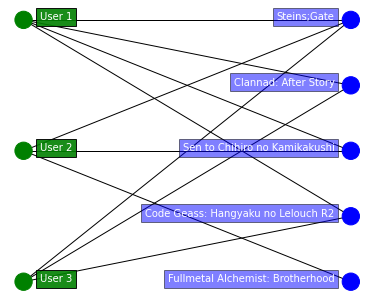

In [142]:
B = nx.Graph()
B.add_nodes_from([1,2,3], bipartite=0) # Add the node attribute "bipartite"
B.add_nodes_from(most_famous[:5], bipartite=1)
n_edges = 20
for _ in range(n_edges):
    user = np.random.randint(1,4)
    anime_index = np.random.randint(5)
    B.add_edge(user, most_famous[anime_index])
    
plt.figure(figsize=(5, 4))
top = nx.bipartite.sets(B)[0]
pos = nx.bipartite_layout(B, top)
nx.draw(B, pos=pos, node_color=['green']*3 + ['blue']*5)
for label, a in list(pos.items())[3:]:
    plt.text(a[0]-0.08,a[1],s=label, c="white", bbox=dict(facecolor='blue', alpha=0.5),horizontalalignment='right')

for label, a in list(pos.items())[:3]:
    plt.text(a[0]+0.08,a[1],s=f"User {4-label}", c="white", bbox=dict(facecolor='green', alpha=0.9),horizontalalignment='left')
    
plt.savefig("bipartite_example.png")
plt.show()

[('Fullmetal Alchemist: Brotherhood', array([ 0.6, -0.6])),
 ('Code Geass: Hangyaku no Lelouch R2', array([ 0.6, -0.3])),
 ('Sen to Chihiro no Kamikakushi', array([0.6, 0. ])),
 ('Clannad: After Story', array([0.6, 0.3])),
 ('Steins;Gate', array([0.6, 0.6]))]

In [111]:
def edge_metric(graph, n1, n2):
    inter = len(list(nx.common_neighbors(graph, n1, n2)))
    union = len(set(graph[n1]) | set(graph[n2])) 
    return inter/union

G = nx.Graph()
for i in tqdm(anime_ids):
    n1 = "a_" + str(i)
    for j in anime_ids:
        n2 = "a_" + str(j)
        G.add_edge(n1, n2, weight=edge_metric(G_bp, n1, n2))

100%|██████████| 40/40 [01:05<00:00,  1.63s/it]


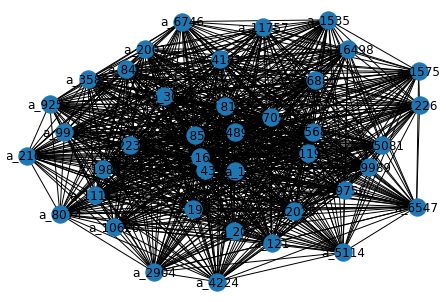

In [102]:
nx.draw_kamada_kawai(G, with_labels=True)

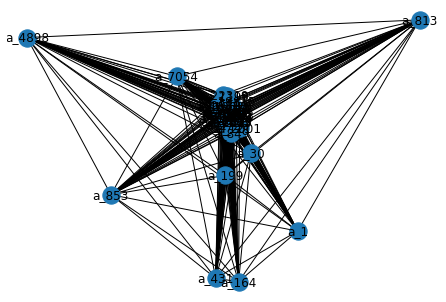

In [108]:
nx.draw_spectral(G, with_labels=True)

In [144]:
n_edges = 500
max_name_length = 20
edgelist = sorted(G.edges(data=True), key=lambda x: x[2]["weight"])[-n_edges:]
edge_color = list(map(lambda x: np.sqrt(x[2]["weight"]), edgelist))
anime_names = list(anime[anime["anime_id"].isin(anime_ids)]["name"])
labels = dict([("a_"+str(i),name[:max_name_length]) for (i,name) in zip(anime_ids,anime_names)])

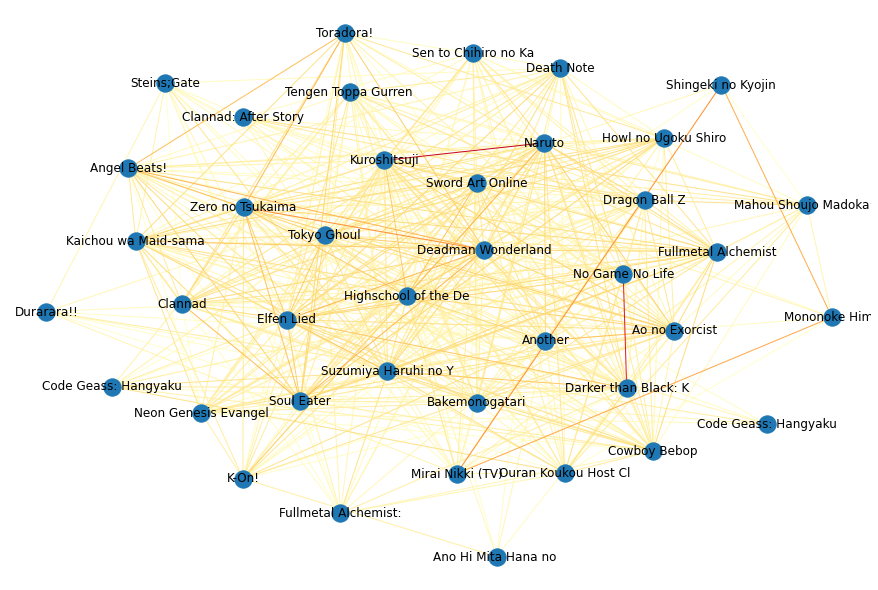

In [148]:
plt.figure(figsize=(12, 8))
nx.draw_spring(G, with_labels=True, edgelist=edgelist, labels=labels, edge_color=edge_color, edge_cmap=plt.get_cmap("YlOrRd"))
plt.savefig("similar_animes.png")
plt.show()